In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import numpy as np
import os
import pandas as pd
import plotly.express as px
import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.patheffects as pe
from itertools import combinations_with_replacement
from dataclasses import dataclass
from collections.abc import Callable
from tqdm import tqdm
from scipy.stats import chi2
from sklearn.model_selection import KFold
import pickle

from data import *
from plotting import *
from regression import *
from utils import *


In [3]:
results_dir = 'results/data-update-08July/'
os.makedirs(results_dir, exist_ok=True)

In [4]:
# Load data
pcd_df = load_pcd_df()

In [5]:
pcd_df

,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Training compute cost (2023 USD),Training dataset size,Sparsity,Utilization notes,Estimated over 1e25 FLOP,Power per GPU,Cluster total TDP,Base model compute,Difference,Difference (share)
0,Gemini 1.0 Ultra,"Multimodal,Language,Vision","Language modelling,Visual question answering,C...",Gemini Team,"SOTA improvement,Training cost",""" Evaluation on a broad range of benchmarks sh...",Hosted access (no API),https://storage.googleapis.com/deepmind-media/...,633.0,Gemini: A Family of Highly Capable Multimodal ...,...,$29827341.92,Gemini 1.0 Ultra,NaN,NaN,NaN,192.0,10560000,NaN,5.000000e+25,100%
1,Llama 3.1-405B,Language,Language modelling/generation,"Abhimanyu Dubey, Abhinav Jauhri, Abhinav Pande...","SOTA improvement,Training cost","High training compute, exceeds 4o and Claude 3...",Open access (restricted use),https://ai.meta.com/research/publications/the-...,NaN,The Llama 3 Herd of Models,...,NaN,NaN,NaN,NaN,NaN,700.0,0,NaN,3.800000e+25,100%
2,GPT-4,"Multimodal,Language,Vision,Image generation",Language modelling,"OpenAI, Josh Achiam, Steven Adler, Sandhini Ag...","Highly cited,SOTA improvement,Training cost","See the paper, p.1: ""On a suite of traditional...",API access,https://arxiv.org/abs/2303.08774,5290.0,GPT-4 Technical Report,...,$40586592.58,GPT-4,GPT-4,(Speculative) SemiAnalysis conjectures that GP...,NaN,400.0,10000000,NaN,2.100000e+25,100%
3,Mistral Large,Language,Chat,NaN,Training cost,~$20M training cost: https://www.wsj.com/tech/...,API access,https://mistral.ai/news/mistral-large/,NaN,"Mistral Large, our new flagship model",...,NaN,Mistral Large,NaN,NaN,NaN,350.0,0,NaN,2.000000e+25,100%
4,Nemotron-4 340B,Language,"Language modelling/generation,Chat","Bo Adler, Niket Agarwal, Ashwath Aithal, Dong ...",Training cost,"~2e25 FLOP, so high training cost, likely >5M",Open source,https://blogs.nvidia.com/blog/nemotron-4-synth...,NaN,NVIDIA Releases Open Synthetic Data Generation...,...,NaN,Nemotron-4 340B,NaN,NaN,NaN,700.0,0,NaN,1.800000e+25,100%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601,Multilingual DNN,Speech,Speech recognition,"G. Heigold, Vincent Vanhoucke, A. Senior, Patr...","SOTA improvement,Training cost",NaN,NaN,https://www.semanticscholar.org/paper/Multilin...,NaN,Multilingual acoustic models using distributed...,...,NaN,Multilingual DNN,NaN,NaN,NaN,NaN,0,NaN,0.000000e+00,NaN
1602,DeViSE,Vision,Semantic embedding,"Andrea Frome, G. Corrado, Jonathon Shlens, Sam...","Highly cited,SOTA improvement",NaN,NaN,https://www.semanticscholar.org/paper/DeViSE%3...,NaN,DeViSE: A Deep Visual-Semantic Embedding Model,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000e+00,NaN
1603,OpenVLA,Robotics,NaN,"Moo Jin Kim, Karl Pertsch, Siddharth Karamchet...",NaN,"claimed SOTA\n\n""OpenVLA outperforms the 55B-p...",Open access (restricted use),https://openvla.github.io/ ; https://arxiv.org...,NaN,OpenVLA: An Open-Source Vision-Language-Action...,...,NaN,NaN,NaN,NaN,NaN,400.0,25600,8.400000e+22,-9.100000e+22,-Infinity
1604,Mistral NeMo,Language,"Language modelling/generation,Code generation","Albert Jiang, Alexandre Sablayrolles, Alexis T...",NaN,NaN,Open source,https://mistral.ai/news/mistral-nemo/,NaN,Mistral NeMo,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000e+00,NaN


In [6]:
pcd_df.loc[pcd_df['System'] == 'Megatron-BERT']['Model accessibility']

216    Unreleased
Name: Model accessibility, dtype: object

In [7]:
access_df = pcd_df.dropna(subset=['Publication date', 'Training compute (FLOP)', 'Model accessibility'])
len(access_df)

548

In [8]:
access_df['Model accessibility'].unique()

array(['Hosted access (no API)', 'Open access (restricted use)',
       'API access', 'Open source', 'Unreleased',
       'Open access (non-commercial)'], dtype=object)

In [9]:
for cat in access_df['Model accessibility'].unique():
    print(cat, len(access_df.loc[access_df['Model accessibility'] == cat]))

Hosted access (no API) 10
Open access (restricted use) 54
API access 27
Open source 203
Unreleased 204
Open access (non-commercial) 50


In [10]:
open_access_categories = ['Open source', 'Open access (restricted use)', 'Open access (non-commercial)']
closed_access_categories = ['API access', 'Hosted access (no API)', 'Unreleased']

In [11]:
open_access_df = access_df.loc[access_df['Model accessibility'].isin(open_access_categories)]
len(open_access_df)

307

In [12]:
closed_access_df = access_df.loc[access_df['Model accessibility'].isin(closed_access_categories)]
len(closed_access_df)

241

In [13]:
# Add column with binary access label
access_df['Model open/closed'] = access_df['Model accessibility'].apply(
    lambda x: 'Open' if x in open_access_categories else 'Closed'
)

/var/folders/s2/stl5t_bn7xg9vdfxxr71rzrc0000gn/T/ipykernel_25721/148813227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_df['Model open/closed'] = access_df['Model accessibility'].apply(


In [14]:
access_df

,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Training dataset size,Sparsity,Utilization notes,Estimated over 1e25 FLOP,Power per GPU,Cluster total TDP,Base model compute,Difference,Difference (share),Model open/closed
0,Gemini 1.0 Ultra,"Multimodal,Language,Vision","Language modelling,Visual question answering,C...",Gemini Team,"SOTA improvement,Training cost",""" Evaluation on a broad range of benchmarks sh...",Hosted access (no API),https://storage.googleapis.com/deepmind-media/...,633.0,Gemini: A Family of Highly Capable Multimodal ...,...,Gemini 1.0 Ultra,NaN,NaN,NaN,192.0,10560000,NaN,5.000000e+25,100%,Closed
1,Llama 3.1-405B,Language,Language modelling/generation,"Abhimanyu Dubey, Abhinav Jauhri, Abhinav Pande...","SOTA improvement,Training cost","High training compute, exceeds 4o and Claude 3...",Open access (restricted use),https://ai.meta.com/research/publications/the-...,NaN,The Llama 3 Herd of Models,...,NaN,NaN,NaN,NaN,700.0,0,NaN,3.800000e+25,100%,Open
2,GPT-4,"Multimodal,Language,Vision,Image generation",Language modelling,"OpenAI, Josh Achiam, Steven Adler, Sandhini Ag...","Highly cited,SOTA improvement,Training cost","See the paper, p.1: ""On a suite of traditional...",API access,https://arxiv.org/abs/2303.08774,5290.0,GPT-4 Technical Report,...,GPT-4,GPT-4,(Speculative) SemiAnalysis conjectures that GP...,NaN,400.0,10000000,NaN,2.100000e+25,100%,Closed
3,Mistral Large,Language,Chat,NaN,Training cost,~$20M training cost: https://www.wsj.com/tech/...,API access,https://mistral.ai/news/mistral-large/,NaN,"Mistral Large, our new flagship model",...,Mistral Large,NaN,NaN,NaN,350.0,0,NaN,2.000000e+25,100%,Closed
4,Nemotron-4 340B,Language,"Language modelling/generation,Chat","Bo Adler, Niket Agarwal, Ashwath Aithal, Dong ...",Training cost,"~2e25 FLOP, so high training cost, likely >5M",Open source,https://blogs.nvidia.com/blog/nemotron-4-synth...,NaN,NVIDIA Releases Open Synthetic Data Generation...,...,Nemotron-4 340B,NaN,NaN,NaN,700.0,0,NaN,1.800000e+25,100%,Open
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,bRSM + cache,Language,NaN,"Jeremy Gordon, David Rawlinson, Subutai Ahmad",NaN,NaN,Unreleased,https://arxiv.org/abs/1912.01116,4.0,Long Distance Relationships without Time Trave...,...,bRSM + cache,NaN,NaN,NaN,NaN,0,NaN,2.130000e+14,100%,Closed
660,life2vec,Medicine,Mortality prediction,"Germans Savcisens, Tina Eliassi-Rad, Lars Kai ...",NaN,NaN,Unreleased,https://arxiv.org/abs/2306.03009,NaN,Using Sequences of Life-events to Predict Huma...,...,life2vec,NaN,NaN,NaN,NaN,0,NaN,1.639051e+14,100%,Closed
664,Vision-based obstacle avoidance system (2005) ...,"Robotics,Vision","Self-driving car,Object detection","Urs Muller, Jan Ben, Eric Cosatto, Beat Flepp,...",NaN,"Not necessarily notable, merely worth adding t...",Unreleased,https://papers.nips.cc/paper_files/paper/2005/...,742.0,Off-Road Obstacle Avoidance through End-to-End...,...,NaN,NaN,NaN,NaN,84.0,84,NaN,6.500000e+13,100%,Closed
672,SPIDER2,Biology,"Protein folding prediction,Proteins","Yuedong Yang, Rhys Heffernan, Kuldip Paliwal, ...",SOTA improvement,"The method provides state-of-the-art, all-in-o...",Open access (non-commercial),https://link.springer.com/protocol/10.1007/978...,NaN,SPIDER2: A Package to Predict Secondary Struct...,...,SPIDER2,NaN,NaN,NaN,NaN,0,NaN,8.540000e+12,100%,Open


## Compute percentile filtering (skipped for now in regression/viz code)

In [15]:
outlier_window_size = 2  # years
start_large_scale_era = '2015-09-01'

In [16]:
pcd_df['Publication date'] = pd.to_datetime(pcd_df['Publication date'])
pcd_df.sort_values('Publication date', inplace=True)
pcd_df.dropna(subset=['Publication date', 'Notability criteria', 'Training compute (FLOP)'], inplace=True)

In [17]:
systems_by_percentile = {}
percentile_interval = 5
for percentile in range(95, -5, -percentile_interval):
  print(percentile)
  percentile_compute_low = np.zeros(len(pcd_df))
  percentile_compute_high = np.zeros(len(pcd_df))
  # Iterate through each row and calculate the 2-year moving average for each date
  for i, (index, row) in enumerate(pcd_df.iterrows()):
    # Define the 2-year window
    start_date = row['Publication date'] - pd.DateOffset(years=outlier_window_size/2)
    end_date = row['Publication date'] + pd.DateOffset(years=outlier_window_size/2)

    # Filter the DataFrame for this window
    window_df = pcd_df[(pcd_df['Publication date'] >= start_date) & (pcd_df['Publication date'] <= end_date)]

    percentile_compute_low[i] = np.percentile(window_df['Training compute (FLOP)'], percentile)
    percentile_compute_high[i] = np.percentile(window_df['Training compute (FLOP)'], percentile + percentile_interval)

  systems_flag = pcd_df['Training compute (FLOP)'] > np.array(percentile_compute_low)
  extra_systems_flag = pcd_df['Training compute (FLOP)'] <= np.array(percentile_compute_high)

  # raise Exception("Edit the following line if you want to consider models released after 2023-12-31.")
  extra_systems = pcd_df['System'][systems_flag & extra_systems_flag & (pcd_df['Publication date'] > pd.to_datetime('2015-09-30'))].values

  systems_by_percentile[percentile] = list(extra_systems)

95
90
85
80
75
70
65
60
55
50
45
40
35
30
25
20
15
10
5
0


In [18]:
systems_by_percentile

{95: ['GNMT',
  'AlphaGo Master',
  'AlphaGo Zero',
  'AlphaZero',
  'ResNeXt-101 32x48d',
  'Meena',
  'GPT-3 175B (davinci)',
  'GShard (dense)',
  'Megatron-Turing NLG 530B',
  'PaLM (540B)',
  'Minerva (540B)',
  'GPT-4',
  'Gemini 1.0 Ultra',
  'Llama 3.1-405B'],
 90: ['NASv3 (CIFAR-10)',
  'FTW',
  'Megatron-BERT',
  'T5-11B',
  'AlphaStar',
  'OpenAI Five',
  'mT5-XXL',
  'Switch',
  'Gopher (280B)',
  'ERNIE 3.0 Titan',
  'Chinchilla',
  'Flan-PaLM 540B',
  'U-PaLM (540B)',
  'GPT-3.5 (text-davinci-003)',
  'PaLM 2',
  'Claude 2',
  'Inflection-2',
  'MegaScale (Production)',
  'Mistral Large',
  'Nemotron-4 340B'],
 85: ['AlphaGo Fan',
  'AlphaGo Lee',
  'JFT',
  'AmoebaNet-A (F=448)',
  'XLNet',
  'Megatron-LM (8.3B)',
  'OpenAI Five Rerun',
  'Turing-NLG',
  'Yuan 1.0',
  'GLaM',
  'LaMDA',
  'OPT-175B',
  'BLOOM-176B',
  'Falcon-180B',
  'Inflection-2.5'],
 80: ['OpenAI TI7 DOTA 1v1',
  'IMPALA',
  'BigGAN-deep 512x512',
  'GPT-2 (1.5B)',
  'iGPT-XL',
  'DALL-E',
  'Meta Ps

In [19]:
compute_percentile_threshold = 50
selected_systems = []
for percentile in range(compute_percentile_threshold, 100, 5):
    selected_systems.extend(systems_by_percentile[percentile])
selected_systems

['BIDAF',
 'Transformer',
 'GPT-1',
 'ProxylessNAS',
 'GBERT-Large',
 'wave2vec 2.0 LARGE',
 'AlphaFold 2',
 'HuBERT',
 'PLATO-XL',
 'ProGen2-xlarge',
 'OmegaPLM',
 'LLaMA-7B',
 'LLaMA-13B',
 'FinGPT-13B',
 'Llama Guard',
 'DeepStack',
 'LSTM (Hebbian, Cache, MbPA)',
 'SciBERT',
 'DD-PPO',
 'ViT-Huge/14',
 'MSA Transformer',
 'M6-T',
 'ADM',
 'DeBERTa',
 'XGLM-7.5B',
 'RETRO-7B',
 'Imagen',
 'NLLB',
 'ESM2-3B',
 'Flan-T5 11B',
 'Llama 2-7B',
 'Llama 2-13B',
 'Nemotron-3-8B',
 'MegaScale (175B)',
 'ResNet-200',
 'QT-Opt',
 'Population-based DRL',
 'Mesh-TensorFlow Transformer 2.9B (translation)',
 'Megatron-LM (355M)',
 'T5-3B',
 'CamemBERT',
 'Noisy Student (L2)',
 'Once for All',
 'ERNIE 3.0',
 'Student of Games',
 'PaLI',
 'StarCoder',
 'Skywork-13B',
 'FunSearch',
 'MM1-30B',
 'Llama 3-8B',
 'ResNet-152 (ImageNet)',
 'ConvS2S (ensemble of 8 models)',
 'PNASNet-5',
 'YOLOv3',
 'Transformer (Adaptive Input Embeddings) WT103',
 'BERT-Large-CAS (PTB+WT2+WT103)',
 'Conformer + Wav2vec 2.

# Top-n frontier filtering

In [20]:
access_df['Publication date (float)'] = datetime_to_float_year(
    pd.to_datetime(access_df['Publication date'])
)

/var/folders/s2/stl5t_bn7xg9vdfxxr71rzrc0000gn/T/ipykernel_25721/3991044387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_df['Publication date (float)'] = datetime_to_float_year(


In [21]:
n = 10

access_df[f'top_{n}_at_release'] = False

for row, model in access_df.iterrows():
    # Filter for models released as of the model release, with the same open/closed status
    date_df = access_df[(access_df['Publication date (float)'] <= model['Publication date (float)']) 
        & (access_df['Model open/closed'] == model['Model open/closed'])]
    # Get the top n models (with the same open/closed status) by compute
    top_n_models = date_df.nlargest(n, 'Training compute (FLOP)')
    # Mark these models in the original dataframe
    access_df.loc[top_n_models.index, f'top_{n}_at_release'] = True

/var/folders/s2/stl5t_bn7xg9vdfxxr71rzrc0000gn/T/ipykernel_25721/1055558449.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_df[f'top_{n}_at_release'] = False


In [22]:
access_df[(access_df['top_10_at_release'] == True) & (access_df['Model open/closed'] == 'Open')]

,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Utilization notes,Estimated over 1e25 FLOP,Power per GPU,Cluster total TDP,Base model compute,Difference,Difference (share),Model open/closed,Publication date (float),top_10_at_release
1,Llama 3.1-405B,Language,Language modelling/generation,"Abhimanyu Dubey, Abhinav Jauhri, Abhinav Pande...","SOTA improvement,Training cost","High training compute, exceeds 4o and Claude 3...",Open access (restricted use),https://ai.meta.com/research/publications/the-...,NaN,The Llama 3 Herd of Models,...,NaN,NaN,700.0,0,NaN,3.800000e+25,100%,Open,2024.560234,True
4,Nemotron-4 340B,Language,"Language modelling/generation,Chat","Bo Adler, Niket Agarwal, Ashwath Aithal, Dong ...",Training cost,"~2e25 FLOP, so high training cost, likely >5M",Open source,https://blogs.nvidia.com/blog/nemotron-4-synth...,NaN,NVIDIA Releases Open Synthetic Data Generation...,...,NaN,NaN,700.0,0,NaN,1.800000e+25,100%,Open,2024.452259,True
9,Llama 3-70B,Language,"Chat,Language modelling/generation,Code genera...",Aaditya Singh; Aaron Grattafiori; Abhimanyu Du...,Significant use,Will almost certainly be very influential and ...,Open access (restricted use),https://ai.meta.com/blog/meta-llama-3/,NaN,Introducing Meta Llama 3: The most capable ope...,...,"""Our most efficient implementation achieves a ...",NaN,700.0,11200000,NaN,6.300000e+24,100%,Open,2024.296544,True
12,Falcon-180B,Language,Language modelling,"Ebtesam Almazrouei, Hamza Alobeidli, Abdulaziz...",Training cost,"""It's currently at the top of the Hugging Face...",Open access (restricted use),https://falconllm.tii.ae/falcon-180b.html; htt...,148.0,The Falcon Series of Open Language Models,...,Estimated training compute: 3.76e24\nFLOPs at ...,NaN,400.0,1638400,NaN,3.760000e+24,100%,Open,2023.680356,True
13,Qwen2-72B,Language,"Chat,Language modelling/generation",Qwen Team,NaN,SOTA claims are against open source models wit...,Open source,https://qwenlm.github.io/blog/qwen2/ \nhttps:/...,NaN,Hello Qwen2,...,NaN,NaN,NaN,0,NaN,3.020000e+24,100%,Open,2024.433094,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,Big-Little Net (speech),Speech,Speech recognition,"Chun-Fu (Richard) Chen, Quanfu Fan, Neil Malli...",SOTA improvement,"""Furthermore, our model surpasses state-of-the...",Open source,https://arxiv.org/abs/1807.03848,86.0,Big-Little Net: An Efficient Multi-Scale Featu...,...,NaN,NaN,NaN,0,NaN,4.290048e+17,100%,Open,2018.524641,True
581,ULM-FiT,Language,Text classification,"Jeremy Howard, Sebastian Ruder",Highly cited,NaN,Open source,https://arxiv.org/abs/1801.06146,1940.0,Universal Language Model Fine-tuning for Text ...,...,NaN,NaN,NaN,0,NaN,2.725380e+17,100%,Open,2018.046544,True
582,Big-Little Net,Vision,Image classification,"Chun-Fu Chen, Quanfu Fan, Neil Mallinar, Tom S...",SOTA improvement,"""On object recognition task, we demonstrated t...",Open source,https://arxiv.org/abs/1807.03848,86.0,Big-Little Net: An Efficient Multi-Scale Featu...,...,NaN,NaN,300.0,0,NaN,2.460480e+17,100%,Open,2018.524641,True
597,DNCON2,Biology,"Proteins,Protein folding prediction","Badri Adhikari, Jie Hou, Jianlin Cheng",NaN,NaN,Open source,https://academic.oup.com/bioinformatics/articl...,173.0,DNCON2: improved protein contact prediction us...,...,NaN,NaN,NaN,0,NaN,9.500000e+16,100%,Open,2018.333333,True


In [23]:
access_df[(access_df['top_10_at_release'] == True) & (access_df['Model open/closed'] == 'Closed')]

,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Utilization notes,Estimated over 1e25 FLOP,Power per GPU,Cluster total TDP,Base model compute,Difference,Difference (share),Model open/closed,Publication date (float),top_10_at_release
0,Gemini 1.0 Ultra,"Multimodal,Language,Vision","Language modelling,Visual question answering,C...",Gemini Team,"SOTA improvement,Training cost",""" Evaluation on a broad range of benchmarks sh...",Hosted access (no API),https://storage.googleapis.com/deepmind-media/...,633.0,Gemini: A Family of Highly Capable Multimodal ...,...,NaN,NaN,192.0,10560000,NaN,5.000000e+25,100%,Closed,2023.930356,True
2,GPT-4,"Multimodal,Language,Vision,Image generation",Language modelling,"OpenAI, Josh Achiam, Steven Adler, Sandhini Ag...","Highly cited,SOTA improvement,Training cost","See the paper, p.1: ""On a suite of traditional...",API access,https://arxiv.org/abs/2303.08774,5290.0,GPT-4 Technical Report,...,(Speculative) SemiAnalysis conjectures that GP...,NaN,400.0,10000000,NaN,2.100000e+25,100%,Closed,2023.204997,True
3,Mistral Large,Language,Chat,NaN,Training cost,~$20M training cost: https://www.wsj.com/tech/...,API access,https://mistral.ai/news/mistral-large/,NaN,"Mistral Large, our new flagship model",...,NaN,NaN,350.0,0,NaN,2.000000e+25,100%,Closed,2024.151781,True
5,MegaScale (Production),Language,Language modelling/generation,"Ziheng Jiang, Haibin Lin, Yinmin Zhong, Qi Hua...",SOTA improvement,Improves SOTA in FLOP utilization for distribu...,Unreleased,https://arxiv.org/abs/2402.15627,10.0,MegaScale: Scaling Large Language Model Traini...,...,NaN,NaN,400.0,4915200,NaN,1.200000e+25,100%,Closed,2024.143567,True
6,Inflection-2,Language,"Language modelling,Language modelling/generati...",NaN,"Significant use,Training cost",Inflection-2 either already powers Pi or soon ...,Hosted access (no API),https://inflection.ai/inflection-2,NaN,Inflection-2: The Next Step Up,...,NaN,NaN,700.0,3500000,NaN,1.001000e+25,100%,Closed,2023.890829,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,Search-Proven Best LSTM,Language,NaN,"R. Józefowicz, Wojciech Zaremba, Ilya Sutskever",Highly cited,NaN,Unreleased,https://proceedings.mlr.press/v37/jozefowicz15...,2207.0,An Empirical Exploration of Recurrent Network ...,...,NaN,NaN,NaN,0,NaN,3.340000e+15,100%,Closed,2015.513690,True
644,LSTM-Char-Large,Language,NaN,"Yoon Kim, Yacine Jernite, David Sontag, Alexan...",Highly cited,NaN,Unreleased,https://arxiv.org/abs/1508.06615,2033.0,Character-Aware Neural Language Models,...,NaN,NaN,NaN,0,NaN,2.650000e+15,100%,Closed,2015.651781,True
653,LBL,Language,NaN,"Andriy Mnih, Yee Whye Teh",NaN,NaN,Unreleased,https://arxiv.org/abs/1206.6426,835.0,A Fast and Simple Algorithm for Training Neura...,...,NaN,NaN,NaN,0,NaN,5.020000e+14,100%,Closed,2012.487852,True
664,Vision-based obstacle avoidance system (2005) ...,"Robotics,Vision","Self-driving car,Object detection","Urs Muller, Jan Ben, Eric Cosatto, Beat Flepp,...",NaN,"Not necessarily notable, merely worth adding t...",Unreleased,https://papers.nips.cc/paper_files/paper/2005/...,742.0,Off-Road Obstacle Avoidance through End-to-End...,...,NaN,NaN,84.0,84,NaN,6.500000e+13,100%,Closed,2005.927618,True


# Best fit

In [24]:
access_df

,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Utilization notes,Estimated over 1e25 FLOP,Power per GPU,Cluster total TDP,Base model compute,Difference,Difference (share),Model open/closed,Publication date (float),top_10_at_release
0,Gemini 1.0 Ultra,"Multimodal,Language,Vision","Language modelling,Visual question answering,C...",Gemini Team,"SOTA improvement,Training cost",""" Evaluation on a broad range of benchmarks sh...",Hosted access (no API),https://storage.googleapis.com/deepmind-media/...,633.0,Gemini: A Family of Highly Capable Multimodal ...,...,NaN,NaN,192.0,10560000,NaN,5.000000e+25,100%,Closed,2023.930356,True
1,Llama 3.1-405B,Language,Language modelling/generation,"Abhimanyu Dubey, Abhinav Jauhri, Abhinav Pande...","SOTA improvement,Training cost","High training compute, exceeds 4o and Claude 3...",Open access (restricted use),https://ai.meta.com/research/publications/the-...,NaN,The Llama 3 Herd of Models,...,NaN,NaN,700.0,0,NaN,3.800000e+25,100%,Open,2024.560234,True
2,GPT-4,"Multimodal,Language,Vision,Image generation",Language modelling,"OpenAI, Josh Achiam, Steven Adler, Sandhini Ag...","Highly cited,SOTA improvement,Training cost","See the paper, p.1: ""On a suite of traditional...",API access,https://arxiv.org/abs/2303.08774,5290.0,GPT-4 Technical Report,...,(Speculative) SemiAnalysis conjectures that GP...,NaN,400.0,10000000,NaN,2.100000e+25,100%,Closed,2023.204997,True
3,Mistral Large,Language,Chat,NaN,Training cost,~$20M training cost: https://www.wsj.com/tech/...,API access,https://mistral.ai/news/mistral-large/,NaN,"Mistral Large, our new flagship model",...,NaN,NaN,350.0,0,NaN,2.000000e+25,100%,Closed,2024.151781,True
4,Nemotron-4 340B,Language,"Language modelling/generation,Chat","Bo Adler, Niket Agarwal, Ashwath Aithal, Dong ...",Training cost,"~2e25 FLOP, so high training cost, likely >5M",Open source,https://blogs.nvidia.com/blog/nemotron-4-synth...,NaN,NVIDIA Releases Open Synthetic Data Generation...,...,NaN,NaN,700.0,0,NaN,1.800000e+25,100%,Open,2024.452259,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,bRSM + cache,Language,NaN,"Jeremy Gordon, David Rawlinson, Subutai Ahmad",NaN,NaN,Unreleased,https://arxiv.org/abs/1912.01116,4.0,Long Distance Relationships without Time Trave...,...,NaN,NaN,NaN,0,NaN,2.130000e+14,100%,Closed,2019.919405,False
660,life2vec,Medicine,Mortality prediction,"Germans Savcisens, Tina Eliassi-Rad, Lars Kai ...",NaN,NaN,Unreleased,https://arxiv.org/abs/2306.03009,NaN,Using Sequences of Life-events to Predict Huma...,...,NaN,NaN,NaN,0,NaN,1.639051e+14,100%,Closed,2023.427618,False
664,Vision-based obstacle avoidance system (2005) ...,"Robotics,Vision","Self-driving car,Object detection","Urs Muller, Jan Ben, Eric Cosatto, Beat Flepp,...",NaN,"Not necessarily notable, merely worth adding t...",Unreleased,https://papers.nips.cc/paper_files/paper/2005/...,742.0,Off-Road Obstacle Avoidance through End-to-End...,...,NaN,NaN,84.0,84,NaN,6.500000e+13,100%,Closed,2005.927618,True
672,SPIDER2,Biology,"Protein folding prediction,Proteins","Yuedong Yang, Rhys Heffernan, Kuldip Paliwal, ...",SOTA improvement,"The method provides state-of-the-art, all-in-o...",Open access (non-commercial),https://link.springer.com/protocol/10.1007/978...,NaN,SPIDER2: A Package to Predict Secondary Struct...,...,NaN,NaN,NaN,0,NaN,8.540000e+12,100%,Open,2016.823924,True


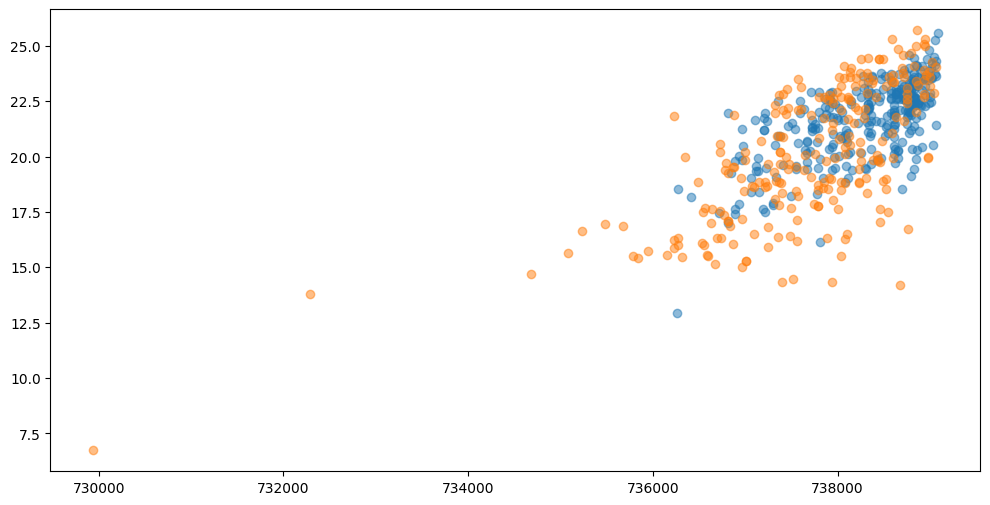

In [25]:
df = access_df

# Filter out NaNs and sort by date
df = (df[['System', 'Training compute (FLOP)', 'Publication date', 'Organization', 'Notability criteria', 'Domain', 'Model open/closed']]
    .rename(columns={'Training compute (FLOP)': 'flop', 'Publication date': 'date'})
    .dropna(subset=['date', 'flop'])
    .assign(date=lambda x: pd.to_datetime(x['date']), log_flop=lambda x: np.log10(x['flop']))
    .sort_values('date'))

time = pd.to_datetime(df['date']).apply(lambda date: date.toordinal()).values
y = df['log_flop'].values

df = pd.DataFrame({
    'y': y,
    'time': time,
    'category': df['Model open/closed'],
    # 'post_break': time >= break_point,
    # 'time_pre': np.minimum(time, break_point),
    # 'time_post': np.maximum(0, time - break_point)
})

plt.figure(figsize=(12, 6))
plt.scatter(df['time'][df['category'] == 'Open'], df['y'][df['category'] == 'Open'], 
            alpha=0.5, label='Open (Data)')
plt.scatter(df['time'][df['category'] == 'Closed'], df['y'][df['category'] == 'Closed'], 
            alpha=0.5, label='Closed (Data)')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     2160.
Date:                Thu, 25 Jul 2024   Prob (F-statistic):          3.15e-160
Time:                        16:43:42   Log-Likelihood:                -760.35
No. Observations:                 200   AIC:                             1531.
Df Residuals:                     195   BIC:                             1547.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7630      2.216      3.052      0.0

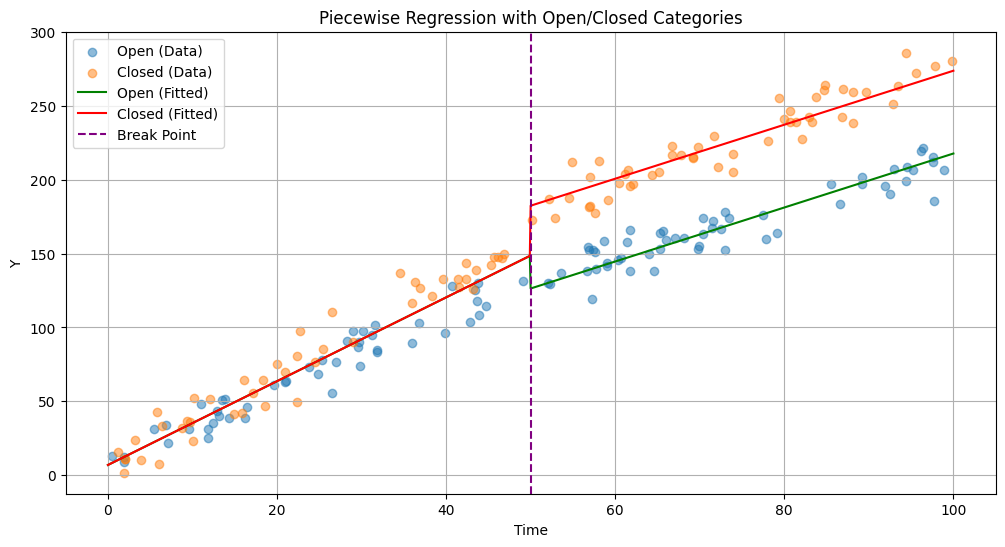

In [26]:
# Generate some example data (replace this with your actual data)
np.random.seed(0)
n = 200
time = np.sort(np.random.uniform(0, 100, n))
category = np.random.choice(['open', 'closed'], n)
break_point = 50

# True parameters (unknown in real scenario)
a_intercept_pre = 10
a_intercept_open = 50
a_intercept_closed = 70
a_pre_open = 2.5
a_pre_closed = 3
a_post_open = 1.5
a_post_closed = 2

# Generate y values with some noise
y = (a_intercept_pre + 
     a_intercept_open * (category == 'open') * (time >= break_point) +
     a_intercept_closed * (category == 'closed') * (time >= break_point) +
     a_pre_open * time * (time < break_point) * (category == 'open') +
     a_pre_closed * time * (time < break_point) * (category == 'closed') +
     a_post_open * time * (time >= break_point) * (category == 'open') +
     a_post_closed * time * (time >= break_point) * (category == 'closed') +
     np.random.normal(0, 10, n))

# Create a DataFrame
df = pd.DataFrame({
    'y': y,
    'time': time,
    'category': category,
    'post_break': time >= break_point,
    'time_pre': np.minimum(time, break_point),
    'time_post': np.maximum(0, time - break_point)
})

# Fit the model
# model = ols(formula='y ~ time_pre + time_post + post_break:C(category)', data=df).fit()

def get_predictors(x, break_points, allow_discontinuities=True, pred_category=None, same_intercepts=None, same_slopes=None):
    intercept_change_points = (0,)
    if allow_discontinuities:
        intercept_change_points += break_points
    slope_change_points = (0,) + break_points
    
    if pred_category == 'open':
        is_open = np.ones(len(x))
    elif pred_category == 'closed':
        is_open = np.zeros(len(x))
    else:
        is_open = (df['category'] == 'open').astype(int).values

    # If same_intercepts or same_slopes are not provided, default to all False
    if same_intercepts is None:
        same_intercepts = [False] * len(intercept_change_points)
    if same_slopes is None:
        same_slopes = [False] * len(slope_change_points)

    # Ensure the lengths match
    assert len(same_intercepts) == len(intercept_change_points), "Length of same_intercepts must match the number of intercept change points"
    assert len(same_slopes) == len(slope_change_points), "Length of same_slopes must match the number of slope change points"

    # Calculate the number of columns needed
    n_intercept_cols = sum(1 if same else 2 for same in same_intercepts)
    n_slope_cols = sum(1 if same else 2 for same in same_slopes)
    n_cols = n_intercept_cols + n_slope_cols

    predictors = np.zeros((len(x), n_cols))

    # Intercept predictors
    col_idx = 0
    for i, (intercept_point, same) in enumerate(zip(intercept_change_points, same_intercepts)):
        if same:
            predictors[:, col_idx] = (x >= intercept_point).astype(int)
            col_idx += 1
        else:
            predictors[:, col_idx] = (x >= intercept_point).astype(int) * is_open
            predictors[:, col_idx + 1] = (x >= intercept_point).astype(int) * (1 - is_open)
            col_idx += 2

    # Slope predictors
    for i, (break_point, same) in enumerate(zip(slope_change_points, same_slopes)):
        if same:
            predictors[:, col_idx] = np.maximum(x - break_point, 0)
            col_idx += 1
        else:
            predictors[:, col_idx] = np.maximum(x - break_point, 0) * is_open
            predictors[:, col_idx + 1] = np.maximum(x - break_point, 0) * (1 - is_open)
            col_idx += 2

    return predictors


x = df['time']
break_points = (50,)
same_intercepts = (True, False)
same_slopes = (True, True)
# predictors = get_predictors(x, break_points, allow_discontinuities=True)
predictors = get_predictors(x, break_points, same_slopes=same_slopes, same_intercepts=same_intercepts)

model = sm.OLS(y, predictors).fit()

# Print the model summary
print(model.summary())

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(df['time'][df['category'] == 'open'], df['y'][df['category'] == 'open'], 
            alpha=0.5, label='Open (Data)')
plt.scatter(df['time'][df['category'] == 'closed'], df['y'][df['category'] == 'closed'], 
            alpha=0.5, label='Closed (Data)')

# Generate points for the fitted lines
time_range = np.linspace(0, 100, 1001)

# Predict for both categories
open_predictors = get_predictors(time_range, break_points, pred_category='open', same_slopes=same_slopes, same_intercepts=same_intercepts)
open_predictions = model.predict(open_predictors)

closed_predictors = get_predictors(time_range, break_points, pred_category='closed', same_slopes=same_slopes, same_intercepts=same_intercepts)
closed_predictions = model.predict(closed_predictors)

# Plot fitted lines
plt.plot(time_range, open_predictions, color='green', label='Open (Fitted)')
plt.plot(time_range, closed_predictions, color='red', label='Closed (Fitted)')

plt.axvline(x=break_point, color='purple', linestyle='--', label='Break Point')
plt.xlabel('Time')
plt.ylabel('Y')
plt.title('Piecewise Regression with Open/Closed Categories')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
predictors

array([[ 1.        ,  0.        ,  0.        ,  0.46954762,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  1.17140842,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  1.85217945,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  1.87898004,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  1.91931983,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  2.01075462,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  2.02183974,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  3.18389295,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  3.91877923,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  5.43379883,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  5.80291603,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  6.02254716,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  6.41474963,  0.        ],
       [ 1.        ,  0.        ,  0. 

In [28]:
df = access_df

In [29]:
# 'external': Filter to the top n models overall
# 'internal': Filter to the top n models within 'Open' and 'Closed' categories
# 'disabled': No filtering
frontier_selection = 'external'  # ['disabled', 'internal', 'external']
top_n = 10  # Filter to the top n models by training compute at time of release
model_selection = 'All models'  # ['All models', 'Language models', 'Google DeepMind models', 'OpenAI models', 'Meta AI models']
filter_alphago_outliers = True
cutoff_date = '2018-01-01'

In [30]:
def find_top_models_up_to_release(df, top_n, category=None):
    """Find the models which were in the top n by compute when they were released."""

    if category == 'Open':
        df = df[df['category'] == 'Open']
    elif category == 'Closed':
        df = df[df['category'] == 'Closed']

    # This set will keep track of models that were ever in the top 10 at their release
    ever_in_top_n = set()

    # Iterate over each date in the DataFrame
    for current_date in df['date'].unique():
        # Get all entries up to the current date
        historical_data = df[df['date'] <= current_date]
        # Find top 10 models by flop count in this subset
        top_n_models = historical_data.nlargest(top_n, 'flop')['System']
        # Update the set of models that were ever in top n
        ever_in_top_n.update(top_n_models)

    # Return DataFrame filtered to only include models that were ever in the top 10
    return df[df['System'].isin(ever_in_top_n)]


def filter_top_models_within_category(df, top_n):
    """Find the models which were in the top n by compute when they were released."""
    # Get top models for Open and Closed categories
    top_open_models = find_top_models_up_to_release(df, top_n, category='Open')
    top_closed_models = find_top_models_up_to_release(df, top_n, category='Closed')
    # Combine the results
    df_filtered = pd.concat([top_open_models, top_closed_models])
    # Sort the combined DataFrame by date
    df_filtered = df_filtered.sort_values('date')
    return df_filtered


# Filter out NaNs and sort by date
df_filtered = (df[['System', 'Training compute (FLOP)', 'Publication date', 'Organization', 'Notability criteria', 'Domain', 'Model open/closed']]
    .rename(columns={'Training compute (FLOP)': 'flop', 'Publication date': 'date', 'Model open/closed': 'category'})
    .dropna(subset=['date', 'flop', 'category'])
    .assign(date=lambda x: pd.to_datetime(x['date']), log_flop=lambda x: np.log10(x['flop']))
    .sort_values('date'))

df_notable = df_filtered.copy() # Store a copy for Top N sensitivity analysis

# Drop Alpha Go Master / Zero
if filter_alphago_outliers:
    mask = (df_filtered["System"] == 'AlphaGo Master') | (df_filtered["System"] == 'AlphaGo Zero')
    df_filtered = df_filtered[~mask]

if frontier_selection == 'external':
    # Filter top models before other filters
    df_filtered = filter_top_models_within_category(df_filtered, top_n)

if model_selection == 'Language models':
    re = 'Language|Multimodal'
    mask = df_filtered['Domain'].str.contains(re, na=False)
    df_filtered = df_filtered[mask]

if frontier_selection == 'internal':
    # Filter top models after other filters
    df_filtered = filter_top_models_within_category(df_filtered, top_n)

# Filter for models after the cutoff date
df_filtered = df_filtered[df_filtered['date'] > cutoff_date]

print(f"{len(df_filtered)}{' top' if frontier_selection != 'disabled' else ''} {model_selection} models found")
print(f"They span {df_filtered['date'].min().strftime('%B %Y')} to {df_filtered['date'].max().strftime('%B %Y')}")

147 top All models models found
They span January 2018 to July 2024


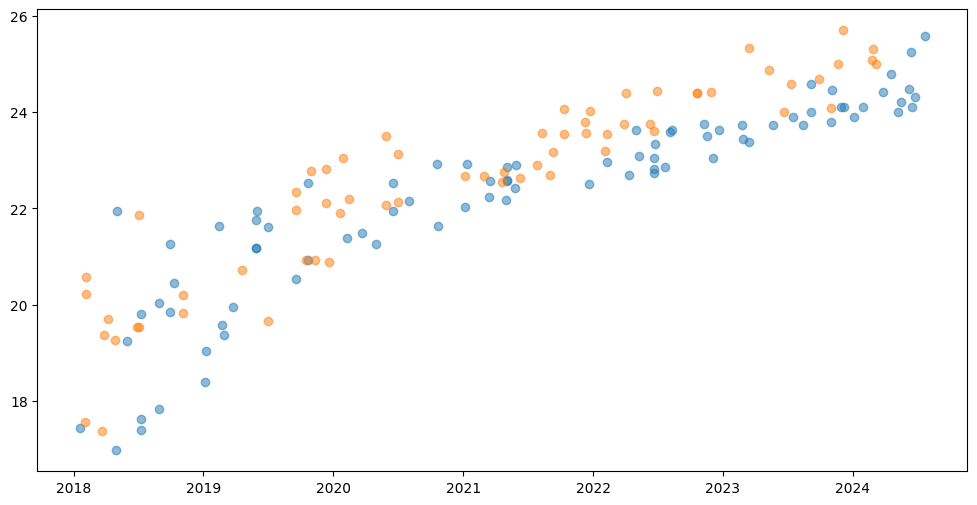

In [31]:
plt.figure(figsize=(12, 6))
plt.scatter(df_filtered['date'][df_filtered['category'] == 'Open'], df_filtered['log_flop'][df_filtered['category'] == 'Open'], 
            alpha=0.5, label='Open (Data)')
plt.scatter(df_filtered['date'][df_filtered['category'] == 'Closed'], df_filtered['log_flop'][df_filtered['category'] == 'Closed'], 
            alpha=0.5, label='Closed (Data)')
plt.show()

In [52]:
# Analysis of best fit to the data

@dataclass
class FitResult:
    p: int = None
    bic: float = None
    rss: float = None
    mse: float = None
    predict: Callable = None


@dataclass
class KinkedFitResult(FitResult):
    break_points: tuple[float] = None
    break_points_dt: float = None
    oom_year_slopes: tuple[float] = None
    intercepts: tuple[float] = None

    # Model properties for each breakpoint combination
    # (for debugging)
    bics: tuple[float] = None
    rsss: tuple[float] = None
    mses: tuple[float] = None
    break_points_list: tuple[tuple[float]] = None
    break_points_dt_list: tuple[tuple[float]] = None


def get_predictors(x, intercept_change_points, slope_change_points, pred_category=None, category=None, same_intercepts=None, same_slopes=None):    
    if pred_category == 'Open':
        is_open = np.ones(len(x))
    elif pred_category == 'Closed':
        is_open = np.zeros(len(x))
    else:
        assert category is not None
        is_open = (category == 'Open').astype(int).values

    # Ensure the lengths match
    assert len(same_intercepts) == len(intercept_change_points), "Length of same_intercepts must match the number of intercept change points"
    assert len(same_slopes) == len(slope_change_points), "Length of same_slopes must match the number of slope change points"

    # Calculate the number of columns needed
    n_intercept_cols = sum(1 if same else 2 for same in same_intercepts)
    n_slope_cols = sum(1 if same else 2 for same in same_slopes)
    n_cols = n_intercept_cols + n_slope_cols

    predictors = np.zeros((len(x), n_cols))

    # Intercept predictors
    col_idx = 0
    for i, (intercept_point, same) in enumerate(zip(intercept_change_points, same_intercepts)):
        if same:
            predictors[:, col_idx] = (x >= intercept_point).astype(int)
            col_idx += 1
        else:
            predictors[:, col_idx] = (x >= intercept_point).astype(int) * is_open
            predictors[:, col_idx + 1] = (x >= intercept_point).astype(int) * (1 - is_open)
            col_idx += 2

    # Slope predictors
    for i, (break_point, same) in enumerate(zip(slope_change_points, same_slopes)):
        if same:
            predictors[:, col_idx] = np.maximum(x - break_point, 0)
            col_idx += 1
        else:
            predictors[:, col_idx] = np.maximum(x - break_point, 0) * is_open
            predictors[:, col_idx + 1] = np.maximum(x - break_point, 0) * (1 - is_open)
            col_idx += 2

    return predictors


def fit_n_phase_exponential(
    df,
    kink_count,
    allow_discontinuities=False,
    same_intercepts=None,
    same_slopes=None,
    min_n_segment=10
):
    # Generate monthly breakpoints between 2010 and 2024
    one_month = pd.DateOffset(months=1)
    break_point_grid = pd.date_range(start=df['date'].min() - one_month, end=df['date'].max() - 4*one_month, freq='MS')
    break_point_grid = [x.toordinal() for x in break_point_grid]

    x = pd.to_datetime(df['date']).apply(lambda date: date.toordinal()).values
    y = df['log_flop'].values

    break_points_list = []
    bics = []
    rsss = []
    mses = []
    models = []

    for break_points in combinations_with_replacement(break_point_grid, kink_count):
        intercept_change_points = (0,)
        if allow_discontinuities:
            intercept_change_points += break_points
        slope_change_points = (0,) + break_points

        # If same_intercepts or same_slopes are not provided, default to all False
        if same_intercepts is None:
            same_intercepts = [False] * len(intercept_change_points)
        if same_slopes is None:
            same_slopes = [False] * len(slope_change_points)

        predictors = get_predictors(
            x,
            intercept_change_points,
            slope_change_points,
            category=df['category'],
            same_slopes=same_slopes,
            same_intercepts=same_intercepts
        )

        # Fit the model
        model = sm.OLS(y, predictors).fit()

        # Calculate BIC manually based on log-likelihood
        n = len(x) # Number of observations
        p = len(model.params) + 2*kink_count + 1 # Number of parameters

        # Calculate log-likelihood under the assumption of normally distributed errors
        # We have to iterate over all points to get their individual log-likelihoods
        log_likelihood = 0
        rss = 0
        invalid_model = False # Discard models with segments with less than 2 points
        for i, break_point in enumerate(slope_change_points):
            left_x = break_point
            right_x = slope_change_points[i + 1] if i + 1 < len(slope_change_points) else np.inf

            segment_predictors = predictors[(left_x <= x) & (x < right_x), :]
            segment_y = y[(left_x <= x) & (x < right_x)]
            segment_n = len(segment_y)

            assert min_n_segment > 2

            if segment_n < min_n_segment:
                invalid_model = True
                break

            y_pred = model.predict(segment_predictors)

            segment_rss = np.sum((y_pred - segment_y)**2)
            assert segment_rss > 0
            segment_mse = segment_rss / segment_n

            segment_log_likelihood = -segment_n/2 * (np.log(2*np.pi) + np.log(segment_rss/segment_n) + 1)
            log_likelihood += segment_log_likelihood
            rss += segment_rss

        if invalid_model:
            continue

        # Compute BIC using the manual method based on the log-likelihood
        bic = p * np.log(n) - 2 * log_likelihood
        # bic = n*np.log(rss/n) + p*np.log(n)

        bics.append(bic)
        rsss.append(rss)
        mses.append(rss/len(df))
        models.append(model)
        break_points_list.append(break_points)

    # Prepare the result object
    best_bic = min(bics)
    best_idx = bics.index(best_bic)
    best_rss = rsss[best_idx]
    best_mse = mses[best_idx]
    best_model = models[best_idx]
    best_break_points = break_points_list[best_idx]

    p = len(best_model.params) + 2*kink_count + 1 # Number of parameters

    # Store the model parameters
    intercept_change_points = (0,)
    if allow_discontinuities:
        intercept_change_points += best_break_points
    slope_change_points = (0,) + best_break_points

    n_intercepts = sum(1 if same else 2 for same in same_intercepts)
    intercepts = best_model.params[:n_intercepts]
    oom_intercepts = np.zeros((2, len(intercept_change_points)))
    for i in range(len(intercept_change_points)):
        if same_intercepts[i]:
            oom_intercepts[0, i] = oom_intercepts[1, i] = intercepts[i]
        else:
            oom_intercepts[0, i] = intercepts[2*i - sum(same_intercepts[:i])]
            oom_intercepts[1, i] = intercepts[2*i + 1 - sum(same_intercepts[:i])]

    # Apply cumulative sum to get the actual slopes
    oom_intercepts = {'open': np.cumsum(oom_intercepts[0]), 'closed': np.cumsum(oom_intercepts[1])}

    n_slopes = len(slope_change_points)
    slopes = best_model.params[n_intercepts:]
    oom_year_slopes = np.zeros((2, n_slopes))  # 2 rows for Open and Closed
    for i in range(n_slopes):
        if same_slopes[i]:
            oom_year_slopes[0, i] = oom_year_slopes[1, i] = 365 * slopes[i]
        else:
            oom_year_slopes[0, i] = 365 * slopes[2*i - sum(same_slopes[:i])]
            oom_year_slopes[1, i] = 365 * slopes[2*i + 1 - sum(same_slopes[:i])]

    # Apply cumulative sum to get the actual slopes
    oom_year_slopes = {'open': np.cumsum(oom_year_slopes[0]), 'closed': np.cumsum(oom_year_slopes[1])}

    def predict(date, category):
        if not isinstance(date, pd.Series):
            date = pd.Series(date)
        x = pd.to_datetime(date).apply(lambda date: date.toordinal()).values

        predictors = get_predictors(
            x,
            intercept_change_points,
            slope_change_points,
            category=category,
            same_slopes=same_slopes,
            same_intercepts=same_intercepts
        )

        return best_model.predict(predictors)

    fit_result = KinkedFitResult(
        p=p,
        bic=best_bic,
        rss=best_rss,
        mse=best_mse,
        break_points=best_break_points,
        predict=predict,
        break_points_dt=[pd.Timestamp.fromordinal(bp) for bp in best_break_points],
        bics=bics,
        rsss=rsss,
        mses=mses,
        oom_year_slopes=oom_year_slopes,
        intercepts=oom_intercepts,
        break_points_list=break_points_list,
        break_points_dt_list=[[pd.Timestamp.fromordinal(bp) for bp in break_points] for break_points in break_points_list],
    )

    return fit_result


fit_em_all = lambda df_fit : {
    "Simple" : fit_n_phase_exponential(df_fit, kink_count=0),
    "Discrete acceleration" : fit_n_phase_exponential(df_fit, kink_count=1),
    "Discontinuity" : fit_n_phase_exponential(df_fit, kink_count=1, allow_discontinuities=True),
    "Same pre-break, different post-break" : fit_n_phase_exponential(
        df_fit, kink_count=1, allow_discontinuities=True, same_intercepts=(True, False), same_slopes=(True, False)
    ),
    "Same pre-break, different intercept post-break" : fit_n_phase_exponential(
        df_fit, kink_count=1, allow_discontinuities=True, same_intercepts=(True, False), same_slopes=(True, True)
    ),
}

# Best model fits
models = fit_em_all(df_filtered)

# K-Fold Cross Validation
def perform_cross_validation(df, k=10, random_state=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    folds_mses = defaultdict(lambda : [])
    for train_index, test_index in kf.split(df):
        train_df, test_df = df.iloc[train_index], df.iloc[test_index]

        # Fit the models on the training set
        fold_models = fit_em_all(train_df)

        # Predict on the test set
        for name,model in fold_models.items():
            try:
                predicted_log_flop = model.predict(test_df["date"], test_df["category"])
            except AttributeError:
                continue
            test_rss = np.sum((predicted_log_flop - test_df["log_flop"])**2)
            test_mse = test_rss / len(test_df)
            folds_mses[name].append(test_mse)

    # Compute mean MSE
    folds_mses = {name: np.mean(folds_mses[name]) for name in folds_mses}

    return folds_mses

folds_mses = perform_cross_validation(df_filtered)

def calculate_lead_time(df, fit_result):
    # Get the final predictions for 'open' and 'closed' categories
    final_date = df['date'].max()
    y_open = fit_result.predict(pd.Series([final_date]), pd.Series(['Open']))[0]
    y_closed = fit_result.predict(pd.Series([final_date]), pd.Series(['Closed']))[0]
    
    # Get the final slope for the 'closed' category
    slope_closed = fit_result.oom_year_slopes['closed'][-1]
    
    # Calculate lead time
    lead_time = (y_closed - y_open) / slope_closed
    
    return lead_time


# Bootstrap
bootstrap_sample_size = 10

rng = np.random.default_rng(43)
bootstrap_bics = defaultdict(lambda : [])
bootstrap_mses = defaultdict(lambda : [])
bootstrap_bic_score_diff = defaultdict(lambda : [])
bootstrap_slopes = defaultdict(lambda : defaultdict(lambda : []))
bootstrap_intercepts = defaultdict(lambda : defaultdict(lambda : []))
bootstrap_breaks = defaultdict(lambda : [])
bootstrap_lead_time_years = defaultdict(lambda : [])
for bootstrap_index in tqdm(range(bootstrap_sample_size)):
    sample = df_filtered.sample(len(df_filtered), replace=True, random_state=rng)
    sample = sample.sort_values('date')

    # Compute BICs
    boot_models = fit_em_all(sample)

    # Compute K fold validation
    boot_folds_mses = perform_cross_validation(sample)

    # Store results
    for name, model in boot_models.items():
        # It might be None if the hyperbolic fails to fit
        if model is None: continue

        bootstrap_bics[name].append(model.bic)
        bootstrap_mses[name].append(boot_folds_mses[name])
        bootstrap_bic_score_diff[name].append(model.bic - boot_models["Simple"].bic)

        if isinstance(model, KinkedFitResult):
            if (len(model.oom_year_slopes['open']) > 0):
                bootstrap_slopes[name]['open'].append(10**model.oom_year_slopes['open'][-1])
            if (len(model.oom_year_slopes['closed']) > 0):
                bootstrap_slopes[name]['closed'].append(10**model.oom_year_slopes['closed'][-1])
            if (len(model.break_points_dt) > 0):
                bootstrap_breaks[name].append(model.break_points_dt[-1])

            # Calculate the lead time between predictions for the open and closed categories
            lead_time_years = calculate_lead_time(sample, model)
            bootstrap_lead_time_years[name].append(lead_time_years)


ci_width = 0.90
qs = [(1 - ci_width)/2, (1 + ci_width)/2]
bootstrap_preferred_percent = {}
bootstrap_slopes_ci = defaultdict(lambda : defaultdict(lambda : []))
for name in models:
    bootstrap_preferred_percent[name] = np.mean(np.array(bootstrap_bic_score_diff[name])<0)
    bootstrap_bics[name] = np.quantile(np.array(bootstrap_bics[name]), qs)
    bootstrap_mses[name] = np.quantile(np.array(bootstrap_mses[name]), qs)
    bootstrap_bic_score_diff[name] = np.quantile(np.array(bootstrap_bic_score_diff[name]), qs)
    try:
        bootstrap_slopes_ci[name]['open'] = np.quantile(np.array(bootstrap_slopes[name]['open']), qs)
        bootstrap_slopes_ci[name]['closed'] = np.quantile(np.array(bootstrap_slopes[name]['closed']), qs)
        bootstrap_breaks[name] = np.quantile(np.array(bootstrap_breaks[name]), qs)
        bootstrap_lead_time_years[name] = np.quantile(np.array(bootstrap_lead_time_years[name]), qs)
    except IndexError:
        pass

# Models with lower BIC score / MSE are preferred.

results = []
for name, model in models.items():
    param_count = model.p
    log_likelihood = (np.log(len(df_filtered))*param_count - model.bic)/2

    param_count_simple = models['Simple'].p
    log_likelihood_simple = (np.log(len(df_filtered))*param_count_simple - models['Simple'].bic)/2

    c2 = chi2.sf(2*(log_likelihood - log_likelihood_simple), df=(param_count - param_count_simple))

    result = {
        "Model": name,
        "BIC" : np.round(model.bic, 2),
        "BIC 90% CI" : np.round(bootstrap_bics[name], 2),
        #"Parameter count": param_count,
        #"Log likelihood": np.round((np.log(len(df_filtered))*param_count - model.bic)/2),
        # "MSE" : model.mse,
        "BIC score diff": np.round(model.bic - models["Simple"].bic, 2),
        "BIC score diff 90% CI": np.round(bootstrap_bic_score_diff[name], 2),
        "Xi²": c2,
        "% times preferred over simple": f"{bootstrap_preferred_percent[name]:.0%}",
        # "bayes factor over simple" : np.exp(-0.5 * (model.bic - models["simple"].bic)),
        "K-fold mean MSE" : np.round(folds_mses[name], 2),
        "K-fold mean MSE 90% CI" : np.round(bootstrap_mses[name], 2),
        "Lead time (years)" : np.round(calculate_lead_time(df_filtered, model), 2),
        "Lead time 90% CI" : np.round(bootstrap_lead_time_years[name], 2),
    }

    try:
        result["Recent slope for closed models (Nx/year)"] = np.round(10**model.oom_year_slopes['closed'][-1], 2)
        result["Recent slope for closed models 90% CI"] = np.round(bootstrap_slopes_ci[name]['closed'], 2)
        result["Recent slope for open models (Nx/year)"] = np.round(10**model.oom_year_slopes['open'][-1], 2)
        result["Recent slope for open models 90% CI"] = np.round(bootstrap_slopes_ci[name]['open'], 2)
        result["Break point"] = model.break_points_dt[-1].strftime('%Y-%m')
        result["Break point 90% CI"] = [date.strftime('%Y-%m') for date in bootstrap_breaks[name]]
    except (AttributeError, IndexError):
        pass
    results.append(result)

results_df = pd.DataFrame(results)

# bayes_factor = np.exp(-0.5 * (kinked_fit.bic - simple_fit.bic))

print("Results")
results_df

100%|██████████| 10/10 [00:18<00:00,  1.87s/it]

Results


,Model,BIC,BIC 90% CI,BIC score diff,BIC score diff 90% CI,Xi²,% times preferred over simple,K-fold mean MSE,K-fold mean MSE 90% CI,Lead time (years),Lead time 90% CI,Recent slope for closed models (Nx/year),Recent slope for closed models 90% CI,Recent slope for open models (Nx/year),Recent slope for open models 90% CI,Break point,Break point 90% CI
0,Simple,382.70,"[356.52, 398.31]",0.00,"[0.0, 0.0]",NaN,0%,0.75,"[0.61, 0.8]",1.08,"[0.8, 1.13, 1.1, 1.17, 1.26, 1.12, 0.94, 1.01,...",9.18,"[8.06, 11.11]",7.24,"[5.96, 9.3]",NaN,NaN
1,Discrete acceleration,295.10,"[265.1, 320.03]",-87.60,"[-102.49, -71.88]",2.413245e-22,100%,0.66,"[0.49, 0.66]",1.30,"[1.13, 1.52]",5.51,"[4.67, 6.52]",4.01,"[3.52, 4.42]",2020-02,"[2019-09, 2020-06]"
2,Discontinuity,301.99,"[264.44, 325.81]",-80.71,"[-105.99, -66.35]",1.489042e-21,100%,0.67,"[0.46, 0.69]",1.21,"[1.11, 1.42]",5.38,"[4.54, 6.25]",4.52,"[3.92, 5.14]",2020-02,"[2019-07, 2020-03]"
3,"Same pre-break, different post-break",295.20,"[257.95, 319.84]",-87.50,"[-111.14, -72.02]",2.535926e-22,100%,0.62,"[0.45, 0.65]",1.19,"[1.07, 1.42]",5.13,"[4.54, 6.41]",4.52,"[4.08, 5.05]",2020-01,"[2019-07, 2020-03]"
4,"Same pre-break, different intercept post-break",290.95,"[254.75, 316.12]",-91.74,"[-114.69, -76.48]",5.590495e-23,100%,0.63,"[0.44, 0.64]",1.07,"[0.95, 1.25]",4.74,"[4.39, 5.17]",4.74,"[4.39, 5.17]",2020-01,"[2019-07, 2020-01]"


In [50]:
# Save results_df
fname = f'compute_regression_analysis_{model_selection}_frontier={frontier_selection}_top{top_n}_cutoff={cutoff_date}.csv'
results_df.to_csv(os.path.join(results_dir, fname), index=False)

# Save bootstrap slopes
fname = f'bootstrap_slopes_{model_selection}_frontier={frontier_selection}_top{top_n}_cutoff={cutoff_date}.pkl'
with open(results_dir + fname, 'wb') as f:
    pickle.dump(dict(bootstrap_slopes), f)

AttributeError: Can't pickle local object '<lambda>.<locals>.<lambda>'

Closed slopes: [0.96284573]
Closed intercepts: [-1923.7067623]
Open slopes: [0.85993489]
Open intercepts: [-1716.36076254]


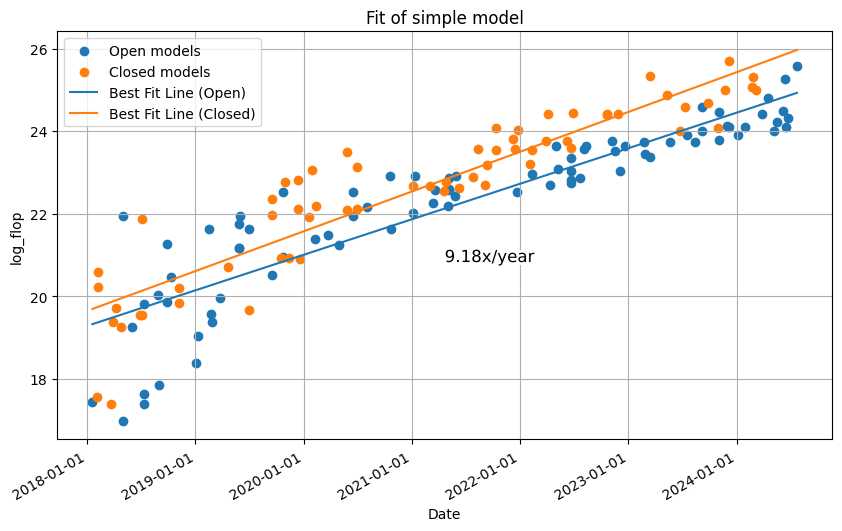

In [49]:
# Graph of the different model fits

model = 'simple'  # ['simple', 'kinked']
colors = {'open': 'C0', 'closed': 'C1'}

# Parameters for the kinked model
kink_count = 1
allow_discontinuities = True
same_intercepts = (True, False)
same_slopes = (True, True)

def plot_model(df, model_type, kink_count=1, verbose=True):
    if model_type == 'simple':
        fit_result = fit_n_phase_exponential(df, 0)
    else:
        fit_result = fit_n_phase_exponential(df, kink_count, allow_discontinuities, same_intercepts, same_slopes)

    print(f"Closed slopes: {fit_result.oom_year_slopes['closed']}")
    print(f"Closed intercepts: {fit_result.intercepts['closed']}")
    print(f"Open slopes: {fit_result.oom_year_slopes['open']}")
    print(f"Open intercepts: {fit_result.intercepts['open']}")

    df_open = df[df['category'] == 'Open']
    df_closed = df[df['category'] == 'Closed']

    # Plot the original data points
    plt.figure(figsize=(10, 6))
    plt.scatter(df_open['date'], df_open['log_flop'], label='Open models')
    plt.scatter(df_closed['date'], df_closed['log_flop'], label='Closed models')

    date_grid = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
    log_flop_open = fit_result.predict(pd.Series(date_grid), pd.Series(['Open'] * len(date_grid))) # we shouldn't need to convert to a Series
    log_flop_closed = fit_result.predict(pd.Series(date_grid), pd.Series(['Closed'] * len(date_grid))) # we shouldn't need to convert to a Series
    plt.plot(date_grid, log_flop_open, color=colors['open'], label='Best Fit Line (Open)')
    plt.plot(date_grid, log_flop_closed, color=colors['closed'], label='Best Fit Line (Closed)')

    # Formatting the plot
    plt.legend()
    if model == 'kinked':
      plt.title(f'Fit of {model_type} model with {kink_count} kinks')
    else:
      plt.title(f'Fit of {model_type} model')
    plt.xlabel('Date')
    plt.ylabel('log_flop')

    # Format the date on the x-axis
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Rotation

    # if kink_count == 0 or model == 'simple':
    #     print(f"The slope is: {fit_result.oom_year_slopes[0]:0.2f} OOM/year ({10**fit_result.oom_year_slopes[0]:0.2f}x/year)")
    # else:
    #     oom_year_slopes_str = ', '.join([f'{x:0.2f}' for x in fit_result.oom_year_slopes])
    #     nx_year_slopes_str = ', '.join([f'{10**x:0.2f}' for x in fit_result.oom_year_slopes])
    #     break_points_str = ', '.join([bp.strftime('%Y-%m-%d') for bp in fit_result.break_points_dt])

    #     print(f"The breakpoints are: [{break_points_str}]")
    #     print(f"The slopes are: [{oom_year_slopes_str}] OOM/year ([{nx_year_slopes_str}] x/year)")

    # Add slope labels
    points = [df['date'].min()] + fit_result.break_points_dt + [df['date'].max()]

    for i in range(len(points) - 1):
        for category in ['open', 'closed']:
            mid = points[i] + (points[i+1] - points[i]) / 2
            y = fit_result.predict(pd.Series([mid]), pd.Series([category]))[0]
            plt.text(mid, y - 2, f'{10**fit_result.oom_year_slopes[category][i]:0.2f}x/year', fontsize=12, color='black', path_effects=[pe.withStroke(linewidth=4, foreground="white")])

    # if verbose:
    #   simple_fit = fit_n_phase_exponential(df, 0)
    #   bayes_factor = np.exp(-0.5 * (fit_result.bic - simple_fit.bic))
    #   unadjusted_bayes_factor = np.exp(-0.5 * (fit_result.bic - (simple_fit.bic + 2*np.log(len(df_filtered)))))

    #   print(f"BIC score: {fit_result.bic}")
    #   bic_score_difference = fit_result.bic - simple_fit.bic
    #   if bic_score_difference > 0:
    #     print(f"The simple exponential is preferred over this fit by a BIC score difference of {fit_result.bic - simple_fit.bic}")
    #   if bic_score_difference < 0:
    #     print(f"This fit is preferred over a simple exponential by a BIC score difference of {-fit_result.bic - simple_fit.bic}")

    plt.legend()
    plt.grid(True)

    # Save plot
    fname = f'compute_regression_{model_selection}_frontier={frontier_selection}_top{top_n}_cutoff={cutoff_date}_{model_type}_kinks={kink_count}.png'
    plt.savefig(os.path.join(results_dir, fname))

    plt.show()

plot_model(df_filtered, model, kink_count)

In [ ]:
#@title Sensitivity analysis to top N choice
run_bootstrap = True #@param {type:'boolean'}
bootstrap_sample_count = 1000 #@param
max_topN = 20 #@param

if run_bootstrap:
    rows = []
    from tqdm import tqdm

    @dataclass
    class BootstrapResult:
        bic_diffs: tuple[float] = None
        oom_year_simples: tuple[float] = None

        # For the kinked model
        break_points_list: tuple[tuple[pd.Timestamp]] = None
        oom_year_slopes: tuple[tuple[float]] = None

    def bootstrap(model, df, sample_size, kink_count=1, allow_discontinuities=False, verbose=True):
        rng = np.random.default_rng(0)

        bootstrap_result = BootstrapResult()
        bootstrap_result.break_points_list = []
        bootstrap_result.oom_year_slopes = []
        bootstrap_result.oom_year_simples = []
        bootstrap_result.bic_diffs = []

        if verbose:
            print('Bootstrapping')
        for bootstrap_index in range(sample_size):
            if verbose:
                if bootstrap_index % 10 == 0:
                    print(f'  Computing bootstrap {bootstrap_index}/{sample_size}')

            sample = df.sample(len(df), replace=True, random_state=rng)
            sample = sample.sort_values('date')

            simple_fit = fit_n_phase_exponential(sample, 0)

            if model == 'hyperbolic':
                fit_result = fit_hyperbolic(sample)
            else:
                fit_result = fit_n_phase_exponential(sample, kink_count, allow_discontinuities)

            # BIC difference over simple exponential
            bic_diff = fit_result.bic - simple_fit.bic
            bootstrap_result.bic_diffs.append(bic_diff)

            bootstrap_result.oom_year_slopes.append(fit_result.oom_year_slopes)
            bootstrap_result.break_points_list.append(fit_result.break_points_dt)
            bootstrap_result.oom_year_simples.append(simple_fit.oom_year_slopes[0])

        bootstrap_result.oom_year_slopes = np.array(bootstrap_result.oom_year_slopes)
        bootstrap_result.break_points_list = np.array(bootstrap_result.break_points_list)
        bootstrap_result.oom_year_simples = np.array(bootstrap_result.oom_year_simples)

        return bootstrap_result


    for top_n in tqdm(range(5, max_topN + 1)):
        df_top = find_top_models_up_to_release(df_notable, top_n)
        df_top = df_top[df_top['date'] > cutoff_date]

        bootstrap_result = bootstrap('kinked', df_top, bootstrap_sample_count, verbose=False)

        ci_width = 0.90
        qs = [(1 - ci_width)/2, 0.5, (1 + ci_width)/2]
        bic_diff_quantiles = np.quantile(bootstrap_result.bic_diffs, qs)
        pos_bic_diff_percent = (np.array(bootstrap_result.bic_diffs) > 0).mean()
        simple_nx_year_quantiles = 10**np.quantile(bootstrap_result.oom_year_simples, qs)

        row = []
        row.append(top_n)
        row.append(f'{bic_diff_quantiles[1]:.2f} (90% CI: {bic_diff_quantiles[0]:.2f} to {bic_diff_quantiles[2]:.2f})')
        row.append(f'{1 - pos_bic_diff_percent:.0%}')
        row.append(f'{simple_nx_year_quantiles[1]:.2f} (90% CI: {simple_nx_year_quantiles[0]:.2f} to {simple_nx_year_quantiles[2]:.2f})')
        rows.append(row)

    df_results = pd.DataFrame(rows, columns=['top_n', 'BIC difference', '% times discontinuity preferred', 'Simple fit slope (x/year)'])

100%|██████████| 16/16 [01:57<00:00,  7.34s/it]


In [ ]:
df_results

,top_n,BIC difference,% times discontinuity preferred,Simple fit slope (x/year)
0,5,-11.72 (90% CI: -28.77 to -1.54),97%,6.91 (90% CI: 5.53 to 8.41)
1,6,-22.91 (90% CI: -44.63 to -5.77),99%,7.89 (90% CI: 6.09 to 10.41)
2,7,-22.94 (90% CI: -41.13 to -9.08),100%,8.81 (90% CI: 7.02 to 11.28)
3,8,-21.75 (90% CI: -38.38 to -8.90),100%,8.70 (90% CI: 6.96 to 11.17)
4,9,-20.84 (90% CI: -36.72 to -7.38),100%,8.77 (90% CI: 7.03 to 11.03)
5,10,-23.47 (90% CI: -41.15 to -6.79),100%,9.11 (90% CI: 7.31 to 11.96)
6,11,-23.68 (90% CI: -40.72 to -9.72),100%,9.40 (90% CI: 7.34 to 12.15)
7,12,-21.34 (90% CI: -38.94 to -7.02),100%,9.25 (90% CI: 7.32 to 11.63)
8,13,-22.36 (90% CI: -38.20 to -8.60),100%,9.65 (90% CI: 7.52 to 12.22)
9,14,-26.54 (90% CI: -42.25 to -12.58),100%,10.28 (90% CI: 8.00 to 13.40)


# Regression

In [ ]:
# tentative
analysis_start_year = 2015
filtered_access_df = access_df[(access_df[f'top_{n}_at_release'] == True) & (access_df['Publication date (float)'] >= analysis_start_year)]


# filtered_access_df = access_df.loc[access_df['System'].isin(selected_systems)]

In [ ]:
filtered_access_df.loc[filtered_access_df['Model open/closed'] == 'Closed',['System', 'Publication date (float)', 'Training compute (FLOP)']].to_csv('test.csv')

In [ ]:
reg_results = fit_ols_regression(
    filtered_access_df,
    ['Publication date (float)'],
    'Training compute (FLOP)',
    logy=True
)
reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     711.5
Date:                Fri, 12 Jul 2024   Prob (F-statistic):           2.17e-60
Time:                        17:57:59   Log-Likelihood:                -244.44
No. Observations:                 160   AIC:                             492.9
Df Residuals:                     158   BIC:                             499.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2056.9430     77.926    -26.396      0.000   -2210.854   -1903.032
x1             1.0287      0.039     26.674      0.000       0.953       1.105
==============================================================================
Omnibus:                       12.661   Durbin-Watson:                   1.048
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               32.836
Skew:                          -0.150   Prob(JB):                     7.41e-08
Kurtosis:                       5.199   Cond. No.                     1.78e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
open_reg_results = fit_ols_regression(
    filtered_access_df[filtered_access_df['Model open/closed'] == 'Open'],
    ['Publication date (float)'],
    'Training compute (FLOP)',
    logy=True
)
open_reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     287.9
Date:                Fri, 12 Jul 2024   Prob (F-statistic):           4.56e-28
Time:                        17:57:59   Log-Likelihood:                -116.70
No. Observations:                  81   AIC:                             237.4
Df Residuals:                      79   BIC:                             242.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1886.2489    112.455    -16.773      0.000   -2110.085   -1662.413
x1             0.9441      0.056     16.968      0.000       0.833       1.055
==============================================================================
Omnibus:                       35.915   Durbin-Watson:                   0.583
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.174
Skew:                          -1.298   Prob(JB):                     1.21e-29
Kurtosis:                       8.720   Cond. No.                     1.98e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.98e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
closed_reg_results = fit_ols_regression(
    filtered_access_df[filtered_access_df['Model open/closed'] == 'Closed'],
    ['Publication date (float)'],
    'Training compute (FLOP)',
    logy=True
)
closed_reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     473.6
Date:                Fri, 12 Jul 2024   Prob (F-statistic):           1.25e-34
Time:                        17:57:59   Log-Likelihood:                -120.06
No. Observations:                  79   AIC:                             244.1
Df Residuals:                      77   BIC:                             248.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2270.6194    105.320    -21.559      0.000   -2480.338   -2060.901
x1             1.1346      0.052     21.762      0.000       1.031       1.238
==============================================================================
Omnibus:                       11.908   Durbin-Watson:                   1.041
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               14.905
Skew:                           0.691   Prob(JB):                     0.000580
Kurtosis:                       4.618   Cond. No.                     1.69e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
print('All:')
print_growth_rates(reg_results)
print('Open:')
print_growth_rates(open_reg_results)
print('Closed:')
print_growth_rates(closed_reg_results)

All:
Adj. R^2=0.82
1.03 OOMs/year (95% CI: 0.95, 1.10)
10.7x/year (95% CI: 9.0x, 12.7x)
doubling time of 4 months (95% CI: 3, 4)
Open:
Adj. R^2=0.78
0.94 OOMs/year (95% CI: 0.83, 1.05)
8.8x/year (95% CI: 6.8x, 11.3x)
doubling time of 4 months (95% CI: 3, 4)
Closed:
Adj. R^2=0.86
1.13 OOMs/year (95% CI: 1.03, 1.24)
13.6x/year (95% CI: 10.7x, 17.3x)
doubling time of 3 months (95% CI: 3, 4)


In [ ]:
closed_reg_results

## Predictions

In [ ]:
pred_start_year = analysis_start_year
pred_end_year = 2025
pred_start_date = f'{pred_start_year}-01-01'
pred_end_date = f'{pred_end_year}-01-01'
num_preds = (pred_end_year - pred_start_year) * 12 + 1

pred_years = pd.DataFrame({'Publication date (float)': np.linspace(pred_start_year, pred_end_year, num_preds)})
pred_years

,Publication date (float)
0,2015.000000
1,2015.083333
2,2015.166667
3,2015.250000
4,2015.333333
...,...
116,2024.666667
117,2024.750000
118,2024.833333
119,2024.916667


In [ ]:
predicted_open_df = get_predictions(open_reg_results, pred_years, ['Publication date (float)'])
predicted_open_df['Publication date'] = predicted_open_df['Publication date (float)'].apply(float_year_to_datetime)
predicted_open_df

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,Publication date (float),Publication date
0,16.140708,0.358602,15.426929,16.854487,13.960519,18.320897,2015.000000,2015-01-01
1,16.219384,0.354213,15.514341,16.924427,14.042039,18.396729,2015.083333,2015-01-31
2,16.298060,0.349831,15.601740,16.994381,14.123524,18.472596,2015.166667,2015-03-02
3,16.376736,0.345455,15.689125,17.064347,14.204974,18.548499,2015.250000,2015-04-02
4,16.455412,0.341086,15.776497,17.134328,14.286387,18.624438,2015.333333,2015-05-02
...,...,...,...,...,...,...,...,...
116,25.267143,0.229138,24.811055,25.723231,23.157223,27.377063,2024.666667,2024-09-01
117,25.345819,0.233160,24.881725,25.809913,23.234154,27.457484,2024.750000,2024-10-01
118,25.424495,0.237205,24.952351,25.896639,23.311047,27.537944,2024.833333,2024-10-31
119,25.503171,0.241271,25.022934,25.983408,23.387900,27.618443,2024.916667,2024-12-01


In [ ]:
predicted_open_df.set_index('Publication date', inplace=True)

In [ ]:
predicted_closed_df = get_predictions(closed_reg_results, pred_years, ['Publication date (float)'])
predicted_closed_df['Publication date'] = predicted_closed_df['Publication date (float)'].apply(float_year_to_datetime)
predicted_closed_df

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,Publication date (float),Publication date
0,15.581533,0.295273,14.993569,16.169498,13.274493,17.888573,2015.000000,2015-01-01
1,15.676083,0.291350,15.095930,16.256235,13.371021,17.981144,2015.083333,2015-01-31
2,15.770632,0.287440,15.198266,16.342997,13.467518,18.073746,2015.166667,2015-03-02
3,15.865181,0.283541,15.300578,16.429784,13.563984,18.166378,2015.250000,2015-04-02
4,15.959730,0.279656,15.402863,16.516597,13.660419,18.259042,2015.333333,2015-05-02
...,...,...,...,...,...,...,...,...
116,26.549247,0.268395,26.014803,27.083690,24.255263,28.843230,2024.666667,2024-09-01
117,26.643796,0.272239,26.101699,27.185892,24.348017,28.939575,2024.750000,2024-10-01
118,26.738345,0.276097,26.188566,27.288124,24.440740,29.035950,2024.833333,2024-10-31
119,26.832894,0.279969,26.275404,27.390384,24.533432,29.132357,2024.916667,2024-12-01


In [ ]:
predicted_closed_df.set_index('Publication date', inplace=True)

## Differences between trends

In [ ]:
NUM_SAMPLES = 1000

In [ ]:
open_reg_results.conf_int()

array([[-2.11008476e+03, -1.66241313e+03],
       [ 8.33364785e-01,  1.05486316e+00]])

In [ ]:
median_date = datetime_to_float_year(pd.to_datetime(filtered_access_df['Publication date'])).median()
median_date

2020.5410686192727

In [ ]:
compute_refs = {}
for key, value in {'open': open_reg_results, 'closed': closed_reg_results}.items():
    X = np.array([median_date, 1])  # dummy 1 value makes this work
    X = sm.add_constant(X)
    ref_preds = value.get_prediction(X).summary_frame()
    compute_ref_low = ref_preds['mean_ci_lower'][0]
    compute_ref_high = ref_preds['mean_ci_upper'][0]
    compute_refs[key] = compute_ref_low, compute_ref_high
compute_refs

{'open': (21.134858382459946, 21.609357913464684),
 'closed': (21.613639784686946, 22.123120298214864)}

In [ ]:
# Open
open_ci = open_reg_results.conf_int()
open_slope = lognorm_from_90_ci(
    10**open_ci[1][0],
    10**open_ci[1][1],
    NUM_SAMPLES,
)
# Closed
closed_ci = closed_reg_results.conf_int()
closed_slope = lognorm_from_90_ci(
    10**closed_ci[1][0],
    10**closed_ci[1][1],
    NUM_SAMPLES,
)

In [ ]:
print_median_and_ci(open_slope)
print_median_and_ci(closed_slope)

Median: 8.8 [90% CI: 6.8, 11]
Median: 14 [90% CI: 11, 17]


In [ ]:
# Calculate when the closed compute trend was equal to the open compute trend today
current_date = '2024-05-01'
current_open_compute_df = predicted_open_df.loc[current_date]
current_open_compute = lognorm_from_90_ci(
    10**current_open_compute_df['mean_ci_lower'],
    10**current_open_compute_df['mean_ci_upper'],
    NUM_SAMPLES,
)
print_median_and_ci(current_open_compute)

Median: 8.5e+24 [90% CI: 3.3e+24, 2.4e+25]


In [ ]:
# Same for closed
current_closed_compute_df = predicted_closed_df.loc[current_date]
current_closed_compute = lognorm_from_90_ci(
    10**current_closed_compute_df['mean_ci_lower'],
    10**current_closed_compute_df['mean_ci_upper'],
    NUM_SAMPLES,
)
print_median_and_ci(current_closed_compute)

Median: 1.5e+26 [90% CI: 4.6e+25, 4.4e+26]


In [ ]:
compute_gap = np.log10(current_closed_compute) - np.log10(current_open_compute)
print(
    f'Open access models are {np.median(compute_gap):.1f} OOMs ' + 
    f'[{np.percentile(compute_gap, 2.5):.1f}; {np.percentile(compute_gap, 97.5):.1f}] ' + 
    'behind closed access models'
)

Open access models are 1.2 OOMs [0.4; 2.0] behind closed access models


In [ ]:
# Calculate when the closed compute trend was equal to the open compute trend today

np.random.seed(42)
open_filtered_access_df =  filtered_access_df[filtered_access_df['Model open/closed'] == 'Open']
closed_filtered_access_df = filtered_access_df[filtered_access_df['Model open/closed'] == 'Closed']

n_bootstrap = 1000
open_filtered_access_bootstrap_indices = [np.arange(0, len(open_filtered_access_df))] + \
                                          [np.random.choice(np.arange(0, len(open_filtered_access_df)), size=len(open_filtered_access_df), replace=True) for _ in range(n_bootstrap)]
closed_filtered_access_bootstrap_indices = [np.arange(0, len(closed_filtered_access_df))] + \
                                            [np.random.choice(np.arange(0, len(closed_filtered_access_df)), size=len(closed_filtered_access_df), replace=True) for _ in range(n_bootstrap)]

current_date_float = 2024.35
results_date_float = []

for i in range(n_bootstrap+1):
    open_reg_results_current = fit_ols_regression(
        open_filtered_access_df.iloc[open_filtered_access_bootstrap_indices[i]],
        ['Publication date (float)'],
        'Training compute (FLOP)',
        logy=True
    )

    closed_reg_results_current = fit_ols_regression(
        closed_filtered_access_df.iloc[closed_filtered_access_bootstrap_indices[i]],
        ['Publication date (float)'],
        'Training compute (FLOP)',
        logy=True
    )

    alpha_o, beta_o = open_reg_results_current.params
    alpha_c, beta_c = closed_reg_results_current.params

    current_log10_compute = alpha_o + beta_o*current_date_float
    results_date_float.append((current_log10_compute - alpha_c)/beta_c)

In [ ]:
print("Point estimate: %.4f" % (results_date_float[0]))
print("Standard error: %.4f years" % (np.std(results_date_float[1:])))

Point estimate: 2023.2731
Standard error: 0.1976 years


In [ ]:
current_date = 2024.25
current_open_compute = open_reg_results.params[1] * current_date + open_reg_results.params[0]
current_open_compute

24.873762088228204

In [ ]:
closed_compute_match_date = (current_open_compute - closed_reg_results.params[0]) / closed_reg_results.params[1]
closed_compute_match_date

2023.1899367655062

In [ ]:
open_time_lag = current_date - closed_compute_match_date
print(f'Open access models are {open_time_lag:.1f} years behind closed access models')

Open access models are 1.1 years behind closed access models


# Plots

In [ ]:
# filter out systems before start of analysis (2015)
access_df_recent = filtered_access_df[filtered_access_df['Publication date'] > pred_start_date]

fig = px.scatter(
    access_df_recent,
    x='Publication date',
    y='Training compute (FLOP)',
    color='Model accessibility',
    hover_data=['System'],
    log_y=True,
)

save_plot(fig, results_dir, f'training_compute_by_model_accessibility {analysis_start_year}')

fig.show()

In [ ]:
fig = px.scatter(
    # access_df,
    # access_df.loc[access_df_recent['System'].isin(selected_systems)],
    access_df_recent,
    x='Publication date',
    y='Training compute (FLOP)',
    color='Model open/closed',
    hover_data=['System'],
    log_y=True,
)

save_plot(fig, results_dir, f'training_compute_by_open_closed {analysis_start_year}')

fig.show()

In [ ]:
predicted_open_df.index


DatetimeIndex(['2015-01-01', '2015-01-31', '2015-03-02', '2015-04-02',
               '2015-05-02', '2015-06-02', '2015-07-02', '2015-08-01',
               '2015-09-01', '2015-10-01',
               ...
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-02',
               '2024-08-01', '2024-09-01', '2024-10-01', '2024-10-31',
               '2024-12-01', '2025-01-01'],
              dtype='datetime64[ns]', name='Publication date', length=121, freq=None)

In [ ]:
fig = px.scatter(
    # access_df,
    # access_df.loc[access_df['System'].isin(selected_systems)],
    access_df_recent,
    x='Publication date (float)',
    y='Training compute (FLOP)',
    color='Model open/closed',
    hover_data=['System'],
    log_y=True,
)

# Marker color
# fig.update_traces(
#     marker=dict(
#         color='rgb(0,100,200)',
#     ),
#     selector=dict(mode='markers'),
# )

# Shade in CI
fig.add_scatter(
    x=predicted_open_df['Publication date (float)'],
    y=10**predicted_open_df['mean_ci_lower'],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
)
fig.add_scatter(
    x=predicted_open_df['Publication date (float)'],
    y=10**predicted_open_df['mean_ci_upper'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(230,100,0,0.2)',
    line=dict(width=0),
    name='95% CI of mean',
)
fig.add_scatter(
    x=predicted_open_df['Publication date (float)'],
    y=10**predicted_open_df['mean'],
    mode='lines',
    line=dict(color='rgb(230,100,0)'),
    name=f'Regression mean (growth rate: {10**open_reg_results.params[1]:.1f}x per year)',
)

fig.add_scatter(
    x=predicted_closed_df['Publication date (float)'],
    y=10**predicted_closed_df['mean_ci_lower'],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
)
fig.add_scatter(
    x=predicted_closed_df['Publication date (float)'],
    y=10**predicted_closed_df['mean_ci_upper'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(0,100,200,0.2)',
    line=dict(width=0),
    name='95% CI of mean',
)
fig.add_scatter(
    x=predicted_closed_df['Publication date (float)'],
    y=10**predicted_closed_df['mean'],
    mode='lines',
    line=dict(color='rgb(0,100,200)'),
    name=f'Regression mean (growth rate: {10**closed_reg_results.params[1]:.1f}x per year)',
)

fig.update_traces(textposition='top center')

# legend on top
fig.update_layout(legend=dict(
    orientation='h',
    yanchor='top',
    y=-0.15,
    xanchor='center',
    x=0.5,
))

# axis labels
fig.update_xaxes(title_text='Publication date')

# title

# update size
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
)

# font size
fig.update_layout(
    font=dict(
        size=14,
    )
)

# axis limits
fig.update_xaxes(range=[pred_start_date, pred_end_date])

# margins
fig.update_layout(margin=dict(l=10, r=10, t=40, b=10))

save_plot(fig, results_dir, f'open_closed_regression {analysis_start_year}')

fig.show()